In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import scipy.integrate as integrate
import warnings
warnings.filterwarnings("ignore")

# Function to convert an array into a column vector. The input x is a list or a row vector.
def col(x):
    return np.array(np.matrix(x)).T

# MLE Experiment: Real greenhouse data

The temperature measurements $T$ (units in °C) and relative humidity $H$ (units in %) in a real rose cultivation greenhouse are modeled as continuous random variables through the random vector $Z = [T, H]^T$. They indicate that assuming $Z$ is a Gaussian vector is not sufficient to model the behavior of temperature and humidity jointly. They ask us to estimate a distribution that better fits the true behavior of the greenhouse. For this, they provide us with 250 joint observations of the temperature $T$ (first column) and humidity $H$ (second column) variables in the file *greenhouseData.txt*.


### a) First, we plot tempertarue vs. humidity, and observer the relationship between the two variables.

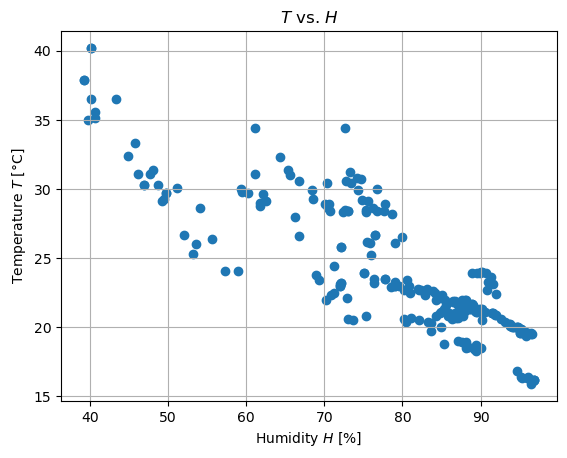

In [2]:
# Import data from .txt
filename = 'greenhouseData.txt'
T = np.loadtxt(filename)[:, 0]
H = np.loadtxt(filename)[:, 1]

# Plot T against H in the R^2 plane.
plt.scatter(H, T)
plt.grid()
plt.xlabel(r'Humidity $H$ [%]')
plt.ylabel(r'Temperature $T$ [°C]')
plt.title(r'$T$ vs. $H$')
plt.show()


A large concentration of data can be noticed between 80% and 90% humidity (for temperatures between 15°C and 25°C), another concentration between 60% and 80% (temperatures between 25°C and 35°C), and a low concentration of data between 40% and 60% humidity (for temperatures between 24°C and 40°C).


### b) We now estimate the best Gaussian distribution of $Z$ (a single Gaussian) using MLE, and indicate the resulting function. 

We plot the temperature vs humidity observations, and overlay the contour of the density function. To estimate the Gaussian distribution, we just need to estimate the vector of means and the covariance matrix.

Mean estimation mu_Z: 
 [[23.8244]
 [79.2048]]

Covariance matrix estimation Q_Z: 
 [[ 24.16586811 -63.29023807]
 [-63.29023807 220.63716562]]



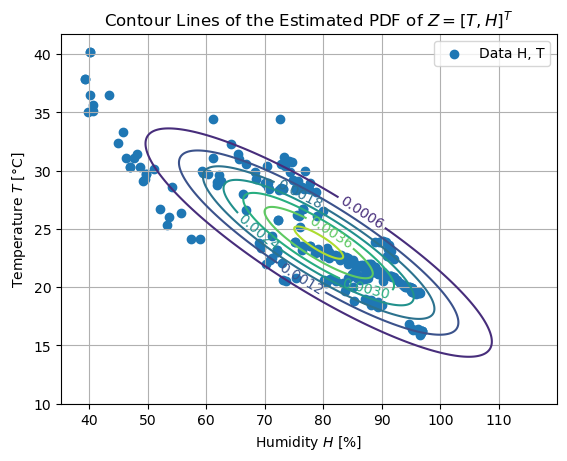

In [3]:
# Create vectors of the form z = [T, H]^T where T is temperature and H is humidity. We will place them in a 2xlen(T) matrix TH, where len(T) = len(H).
TH = np.zeros((2, len(T)))
n, m = np.shape(TH)

# Fill the TH matrix
for i in range(m):
    TH[0, i] = T[i]
    TH[1, i] = H[i]

# Create the mean estimation mu_Z
mu_Z = np.zeros((2,1))
for i in range(m):
    mu_Z = mu_Z + col(TH[:, i])
mu_Z = mu_Z/m
print(f'Mean estimation mu_Z: \n {mu_Z}\n')

# Create the covariance matrix estimation
Q_Z = np.zeros((2,2))
for i in range(m):
    Q_Z = Q_Z + (col(TH[:,i])-mu_Z)@(col(TH[:,i])-mu_Z).T
Q_Z = Q_Z/(m-1)
print(f'Covariance matrix estimation Q_Z: \n {Q_Z}\n')

# Generate vectors with 'h' and 't' values to create a grid (H1, T1) on which to draw the contour plots.
step = 0.05
h = np.arange(40, 120, step)
t = np.arange(10, 40, step)

# Generate the grid (H1, T1). H1 and T1 are matrices representing points in the R^2 plane.
H1, T1 = np.meshgrid(h, t)

# Use the multivariate_normal function to define the Gaussian function along the Z axis generated with the different data in H1 and T1.
# Define the vector Z as the Gaussian pdf represented by the mean vector mu_Z and covariance matrix Q_Z.
pos = np.dstack((T1, H1))
rv = multivariate_normal([float(mu_Z[0]), float(mu_Z[1])], Q_Z)
Z = rv.pdf(pos)

# Plot the contour plots of the pdf of Z along with the T and H data provided in the text file.
fig, ax = plt.subplots()
CS = plt.contour(H1, T1, Z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_xlabel(r'Humidity $H$ [%]')
ax.set_ylabel(r'Temperature $T$ [°C]')
ax.set_title(r'Contour Lines of the Estimated PDF of $Z = [T, H]^T$')
ax.grid()
plt.scatter(H, T)
plt.legend(['Data H, T'])
plt.show()


It can be noticed that assuming $Z$ is a joint Gaussian random vector is not entirely sufficient to provide a good approximation of the relationship between temperature and humidity because although the center of the Gaussian bell is located at a site of high data concentration, there are three different areas of high data concentration that a single Gaussian function cannot cover and would assign a low probability of occurrence to data that actually has a higher probability of occurrence.


### c) We implement the EM algorithm and estimate the density function Z as a combination of two Gaussian density functions. That is,
#### $$f_Z(z) = \sum_{k=1}^{2} \alpha_k N(z; \mu_k, Q_k) $$

We plot the observations again, and overlay the contour of the combined density function $f_Z(z)$ (NOT the contour of each individual base density function separately) for several iterations of the algorithm.

In [4]:
# Multivariable Gaussian probability density function.
def gauss(x, mu, Cx):
    n = np.shape(Cx)[0]
    return (1/(np.sqrt((2*np.pi)**(n)*(np.linalg.det(Cx)))))*np.exp((-1/2)*(np.transpose(x-mu)@np.linalg.inv(Cx))@(x-mu))

# Function to create a new list of thetas (parameters), depending on the number of functions n to be combined.
def create_thetas(n):
    x = [[] for num in range(n)]
    return x

# Function to plot results of the EM algorithm for combining 2 Gaussians
def plot_2_gaussians(c, alphas, params):

    HPoints = []
    TPoints = []

    range_vals = range(0, 120, 1)

    for val in range_vals:
        HPoints.append(val)
        TPoints.append(val)

    # Z values as a matrix
    ZPoints = np.ndarray((len(HPoints), len(TPoints)))

    # Calculate the value for each pair of coordinates h, t
    for h in HPoints:
        for t in TPoints:
            v = np.array([[HPoints[h]], [TPoints[t]]])
            f = alphas[0]*gauss(v, params[0][0], params[0][1]) + alphas[1]*gauss(v, params[1][0], params[1][1])
            ZPoints[h][t] = f

    # Plot
    plt.figure()
    contours = plt.contour(HPoints, TPoints, ZPoints)
    plt.clabel(contours, inline=1, fontsize=10)
    plt.grid()
    plt.scatter(H, T)
    plt.title(f'Temperature vs Humidity (iteration {c})')
    plt.xlabel(r'Humidity $H$ [%]')
    plt.ylabel(r'Temperature $T$ [°C]')
    plt.xlim([35, 105])
    plt.ylim([10, 43])
    plt.show()


# Function to plot results of the EM algorithm for combining 3 Gaussians
def plot_3_gaussians(c, alphas, params):

    HPoints = []
    TPoints = []

    range_vals = range(0, 120, 1)

    for val in range_vals:
        HPoints.append(val)
        TPoints.append(val)

    # Z values as a matrix
    ZPoints = np.ndarray((len(HPoints), len(TPoints)))

    # Calculate the value for each pair of coordinates h, t
    for h in HPoints:
        for t in TPoints:
            v = np.array([[HPoints[h]], [TPoints[t]]])
            f = alphas[0]*gauss(v, params[0][0], params[0][1]) + alphas[1]*gauss(v, params[1][0], params[1][1]) + alphas[2]*gauss(v, params[2][0], params[2][1])
            ZPoints[h][t] = f

    # Plot
    plt.figure()
    contours = plt.contour(HPoints, TPoints, ZPoints)
    plt.clabel(contours, inline=1, fontsize=10)
    plt.grid()
    plt.scatter(H, T)
    plt.title(f'Temperature vs Humidity (iteration {c})')
    plt.xlabel(r'Humidity $H$ [%]')
    plt.ylabel(r'Temperature $T$ [°C]')
    plt.xlim([35, 105])
    plt.ylim([10, 43])
    plt.show()


### Definition of EM Algorithm

In [5]:
# Inputs
# maxIt: maximum iterations allowed for the algorithm.
# tol: tolerance of the algorithm for the termination condition.
# k: number of Gaussian functions to be combined.
# thetak0: list of thetak parameters, each element of the list is a list containing a mean and a covariance matrix.
# alphak: list of alphak parameters, each element of the list is an alpha value.
# data: array of the data on which to find the composite density function. Entered as a matrix where each row is a data point and each column is a component of the data.

# Outputs
# thetak_final: array of parameters of the combined functions that form the composite function best fitting the data.
# alphak_final: array of weights of the combined functions that form the composite function best fitting the data.
# c: Number of iterations taken by the algorithm
def EM(maxIt, tol, k, thetak0, alphak, data):

    c = 0 # Counter for the while loop.
    m = len(data) # Number of data points.
    Y = np.zeros((m, len(thetak0))) # Gamma matrix: each column corresponds to each gamma_k.
    norma = 100 # Norm for the termination condition.
    regu = 0.01*np.eye(2)  # Regularization parameter.

    while(c < maxIt and norma > tol ):

        # E-Step
        den = 0
        for r in range(len(thetak0)):
            Nm = np.zeros((m, 1))
            for i in range(m):
                Nm[i] = gauss(col(data[i]), thetak0[r][0], thetak0[r][1] + regu)
            den = den + alphak[r]*Nm

        num = 0
        for r in range(len(thetak0)):
            Nm = np.zeros((m, 1))
            for i in range(m):
                Nm[i] = gauss(col(data[i]), thetak0[r][0], thetak0[r][1] + regu)
            num = alphak[r]*Nm
            Y[:, r] = col(np.divide(num, den)) # Filling the gamma matrix.

        # M-Step

        # Calculate Nk in this loop
        Nk = []
        suma = 0
        for j in range(len(thetak0)):
            suma = 0
            for i in range(m):
                suma = suma + Y[:, j][i]
            Nk.append(suma)

        # Calculate alphak in this loop
        alphak = []
        for i in range(len(thetak0)):
            alphak.append(Nk[i]/m)

        # Calculate the new means (muk).
        muk = []
        suma = 0
        for j in range(len(thetak0)):
            suma = 0
            for i in range(m):
                suma = suma + Y[:, j][i]*col(data[i])
            muk.append(suma/Nk[j])

        # Calculate the new covariance matrices (Ck).
        Ck = []
        suma = 0
        for j in range(len(thetak0)):
            suma = 0
            for i in range(m):
                datum = col(data[i])
                suma = suma + Y[:, j][i]*(datum-muk[j])@(datum-muk[j]).T
            Ck.append(suma/Nk[j])

        # Create a new list of thetas, to then save those found in the current iteration.
        thetak_new = create_thetas(len(thetak0))
        for i in range(len(thetak0)):
            thetak_new[i].append(muk[i])
            thetak_new[i].append(Ck[i])

        # Calculate the difference between the new and previous parameters and calculate their norm to see if they have similar values.
        norma = np.linalg.norm(thetak_new[0][0] - thetak0[0][0])

        # The "new" value of thetak will now be used in the next iteration.
        thetak0 = thetak_new
        c += 1
        
        # Plot the result for a certain number of iterations.
        its = [1, 5, 10, 15, 20, 25, 30, 35, 50, 75, 100]
        # If 2 Gaussians were combined
        if k == 2:
            for it in its:
                if c == it:
                    plot_2_gaussians(it, alphak, thetak0)
        elif k == 3: # If 3 Gaussians were combined
            for it in its:
                if c == it:
                    plot_3_gaussians(it, alphak, thetak0)

    # When any of the termination conditions are met (iterations or norm).
    thetak_final = thetak0
    alphak_final = alphak

    return thetak_final, alphak_final, c


### 2-Gaussian combination

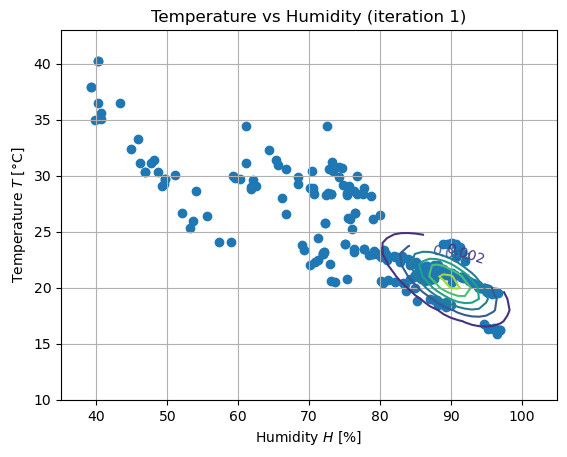

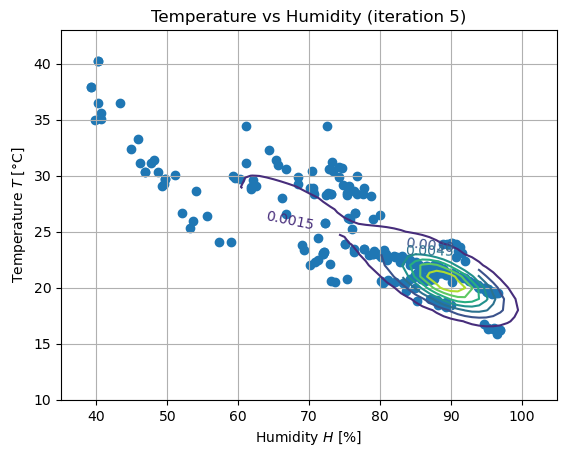

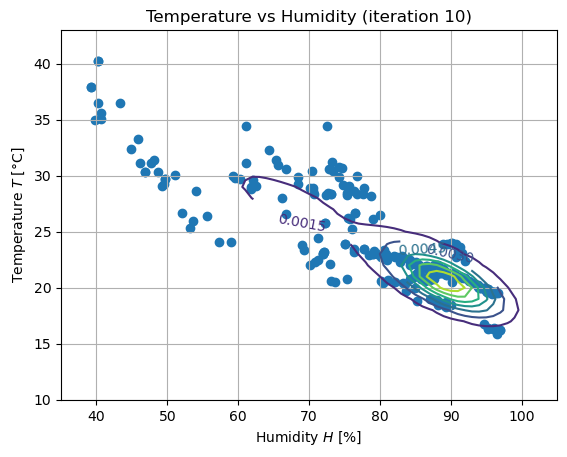

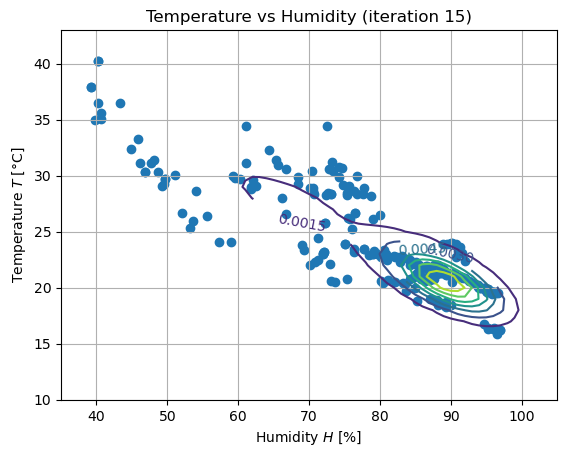

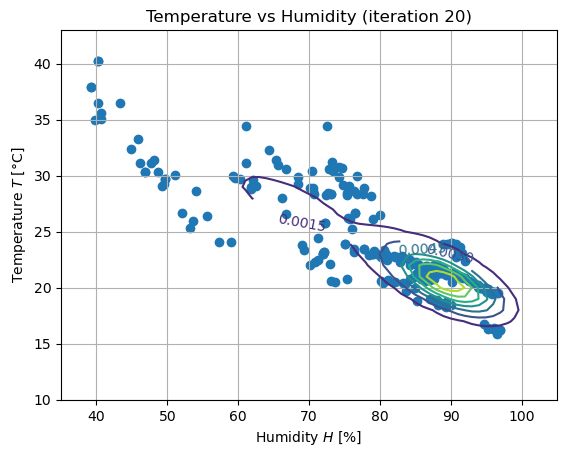

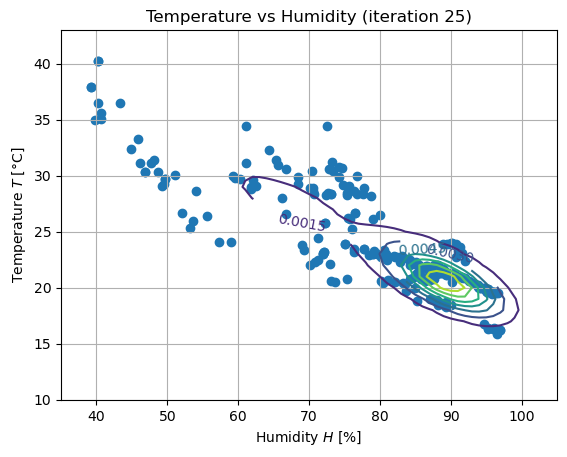

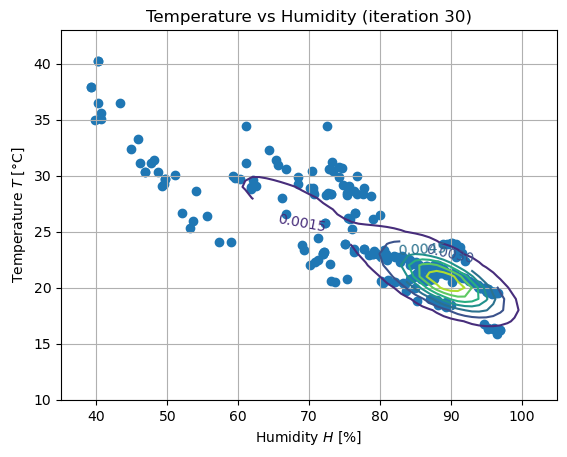

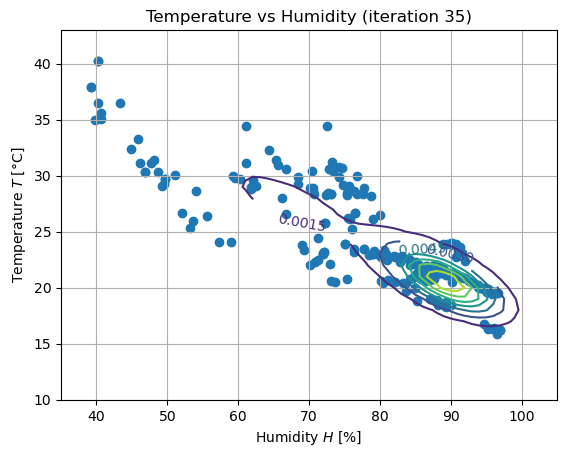

In [6]:
# Initial conditions
k = 2

mu1 = np.array([[20], [70]])
mu2 = np.array([[30], [90]])

C1 = np.eye(2)
C2 = np.eye(2)

thetak = []
theta1 = [mu1, C1]
theta2 = [mu2, C2]

thetak.append(theta1)
thetak.append(theta2)

alphak = []
alpha1 = 1/2
alpha2 = 1/2

alphak.append(alpha1)
alphak.append(alpha2)

maxIts = 1000
tol = 10**-5

TH2 = TH.T

# Algorithm is run
params2, alphas2, its2 = EM(maxIts, tol, k, thetak, alphak, TH2)


### Graph of the result of the algorithm upon convergence

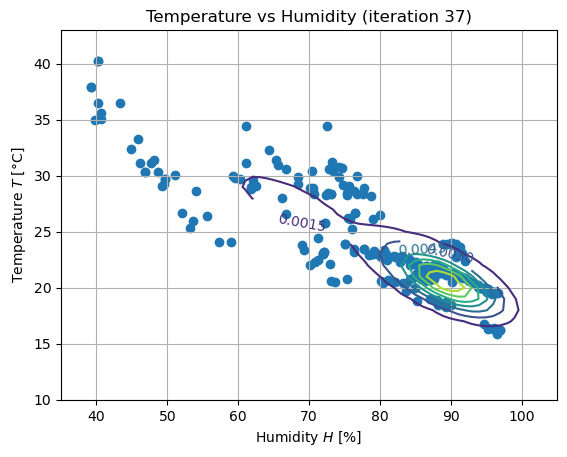

FINAL RESULTS

Number of iterations: 37

Mean of the first function:
[[27.66458727]
 [67.26441891]]

Covariance matrix of the first function:
[[ 21.04620146 -45.92467746]
 [-45.92467746 187.80100245]]

alpha_1 = 0.458
--------------------

Mean of the second function:
[[20.58238175]
 [89.28528062]]

Covariance matrix of the second function:
[[ 3.66068843 -6.0919183 ]
 [-6.0919183  24.7500881 ]]

alpha_2 = 0.542


In [7]:
plot_2_gaussians(its2, alphas2, params2)
print(f'FINAL RESULTS\n')
print(f'Number of iterations: {its2}\n')
print(f'Mean of the first function:\n{params2[0][0]}\n')
print(f'Covariance matrix of the first function:\n{params2[0][1]}\n')
print(f'alpha_1 = {np.round(alphas2[0], 3)}')
print('--------------------\n')
print(f'Mean of the second function:\n{params2[1][0]}\n')
print(f'Covariance matrix of the second function:\n{params2[1][1]}\n')
print(f'alpha_2 = {np.round(alphas2[1], 3)}')


### d) We now repeat section c) with 3 Gaussian functions. We indicate which of the three results (i.e., 1, 2, or 3 Gaussians) was considered to generate a better fit to the data.


#### 3-Gaussian Combination

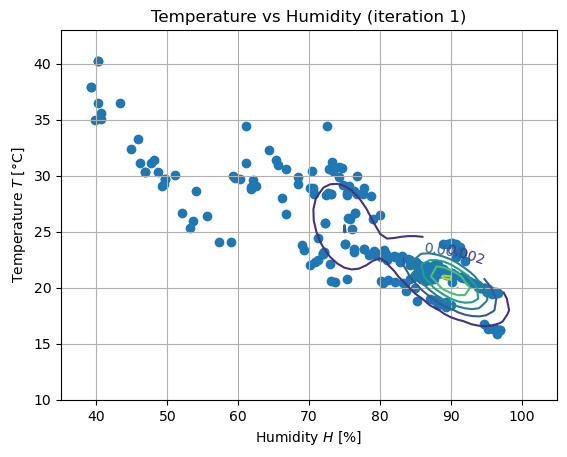

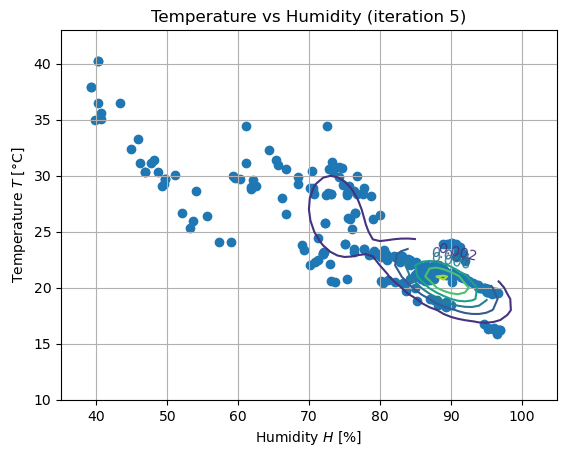

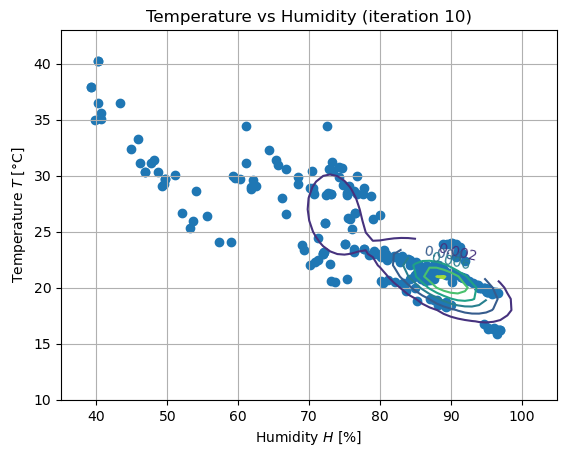

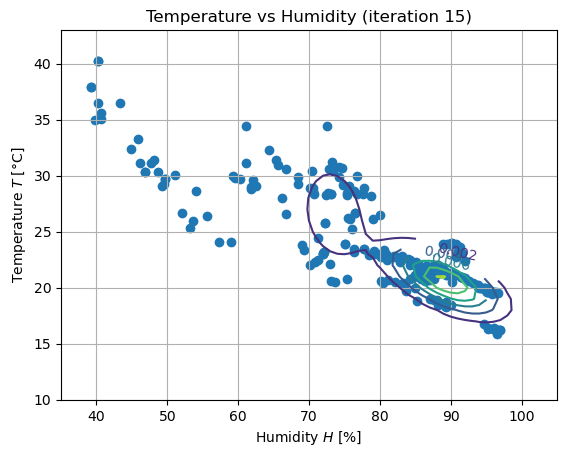

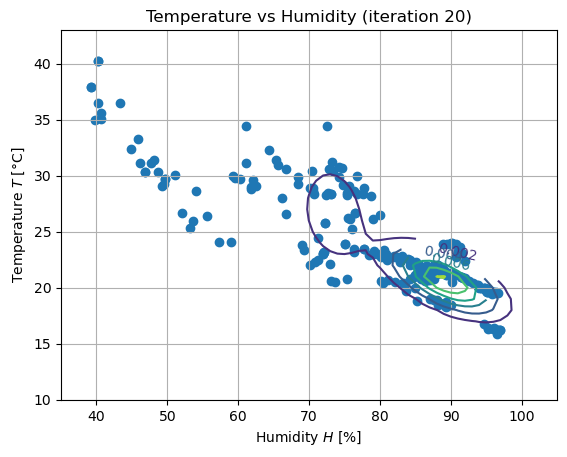

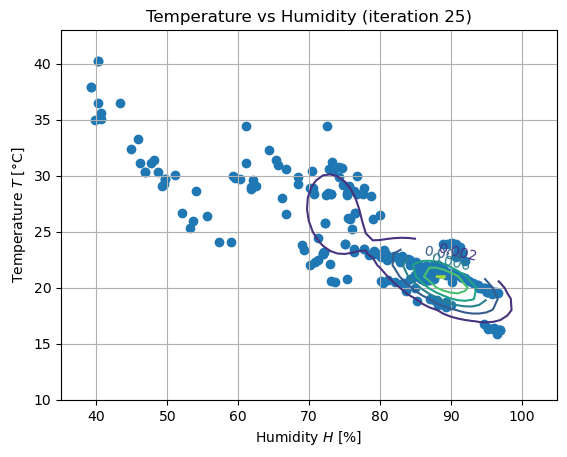

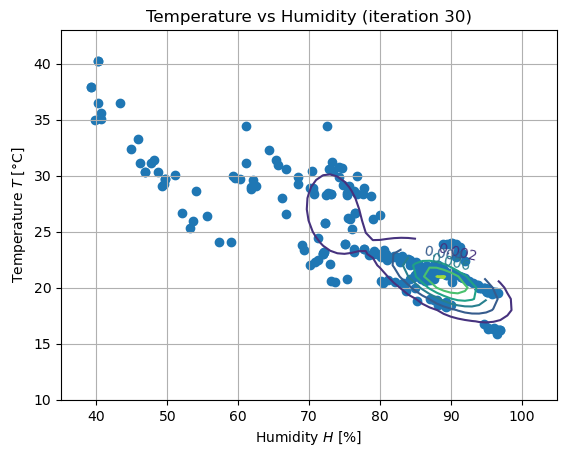

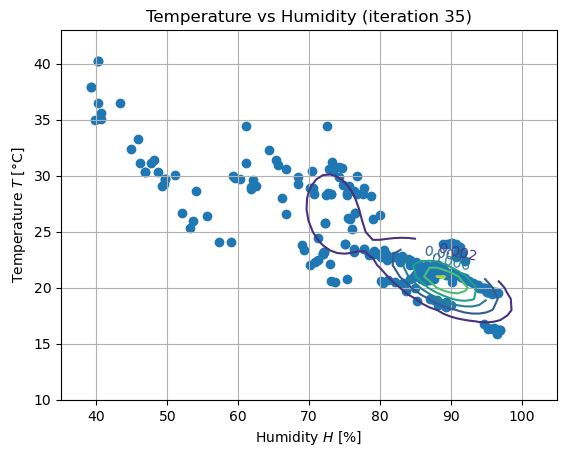

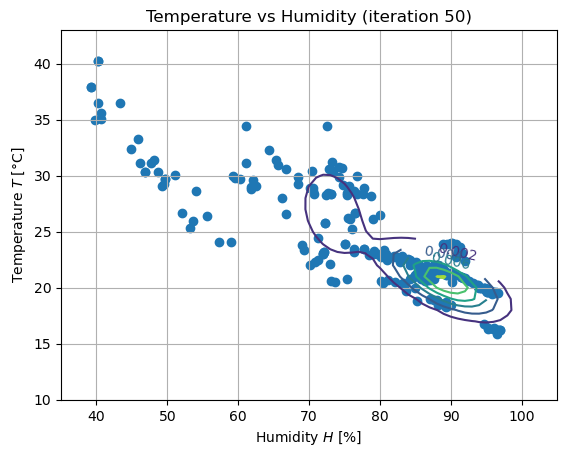

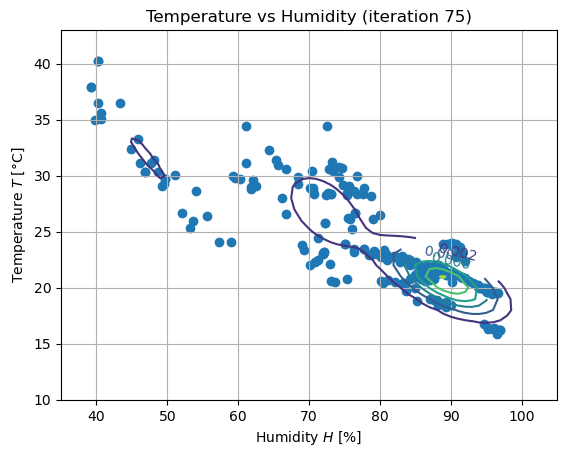

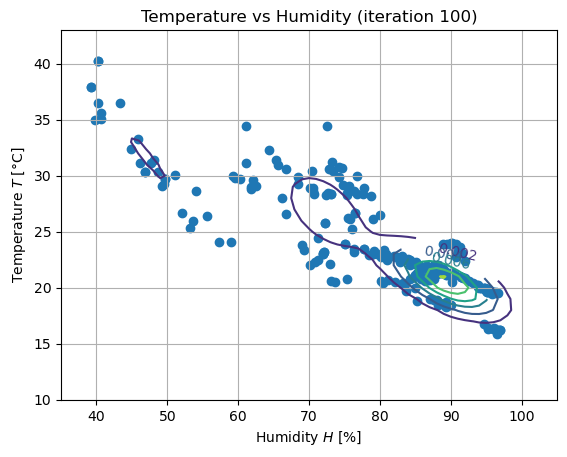

In [8]:
k = 3

mu1 = np.array([[20], [70]])
mu2 = np.array([[30], [90]])
mu3 = np.array([[30], [60]])

C1 = np.eye(2)
C2 = np.eye(2)
C3 = np.eye(2)

thetak = []
theta1 = [mu1, C1]
theta2 = [mu2, C2]
theta3 = [mu3, C3]

thetak.append(theta1)
thetak.append(theta2)
thetak.append(theta3)

alphak = []
alpha1 = 1/3
alpha2 = 1/3
alpha3 = 1/3

alphak.append(alpha1)
alphak.append(alpha2)
alphak.append(alpha3)

maxIts = 1000
tol = 10**-5

TH2 = TH.T

# Run the algorithm
params3, alphas3, its3 = EM(maxIts, tol, k, thetak, alphak, TH2)


#### Graph of the result of the algorithm upon convergence


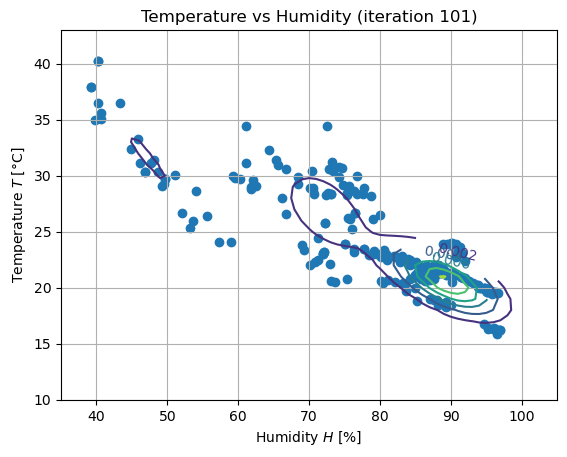

FINAL RESULTS
Number of iterations: 101

Mean of the first function:
[[26.88264238]
 [72.24202129]]

Covariance matrix of the first function:
[[12.12630931 -9.41311052]
 [-9.41311052 32.53662372]]

alpha_1 = 0.313
--------------------

Mean of the second function:
[[20.59024926]
 [89.45607774]]

Covariance matrix of the second function:
[[ 3.74190441 -5.60730383]
 [-5.60730383 22.82868432]]

alpha_2 = 0.572
--------------------

Mean of the third function:
[[31.56002422]
 [47.27707152]]

Covariance matrix of the third function:
[[ 20.16885683 -24.09179452]
 [-24.09179452  31.96415532]]

alpha_3 = 0.115


In [9]:
plot_3_gaussians(its3, alphas3, params3)
print(f'FINAL RESULTS')
print(f'Number of iterations: {its3}\n')
print(f'Mean of the first function:\n{params3[0][0]}\n')
print(f'Covariance matrix of the first function:\n{params3[0][1]}\n')
print(f'alpha_1 = {np.round(alphas3[0], 3)}')
print('--------------------\n')
print(f'Mean of the second function:\n{params3[1][0]}\n')
print(f'Covariance matrix of the second function:\n{params3[1][1]}\n')
print(f'alpha_2 = {np.round(alphas3[1], 3)}')
print('--------------------\n')
print(f'Mean of the third function:\n{params3[2][0]}\n')
print(f'Covariance matrix of the third function:\n{params3[2][1]}\n')
print(f'alpha_3 = {np.round(alphas3[2], 3)}')


It is clear that the combination of 3 Gaussians generates the best fit to the data compared to the combination of 2 Gaussians and just 1 (assuming that Z is a joint Gaussian random vector). This can be clearly seen from the previous graph, where there is a Gaussian bell for each of the three areas of the plane where there was a higher concentration of data.


### e) There are 50 new temperature data points in the file *greenhouse50temp.txt* for which the associated humidity values are unknown.

#### i) Unrestricted MMSE estimator

With the model obtained in item b), we obtain an unrestricted MMSE estimator of $H$ based on the observations of $T$. In this case, since only a joint Gaussian is available, this unrestricted estimator is the same as the linear one. We then estimate the associated humidity observations for the 50 temperature observations collected. Finally, a plot of $T$ vs $\hat{H}$, where $\hat{H}(t)$ refers to the humidity estimation based on the temperature observation $t$, is presented.

The joint PDF resulting from these estimated data is given by

$$f_Z(z) = \frac{1}{2\pi\sqrt{\det{Q_Z}}}\exp\left({-\frac{1}{2}}(z - \mu_Z)^T Q_Z^{-1} (z - \mu_Z)\right)$$

where

$$z = \begin{bmatrix} t \\ h \end{bmatrix}$$

$$\mu_Z = \begin{bmatrix} \mu_T \\ \mu_H \end{bmatrix} = \begin{bmatrix} 23.824 \\ 79.205 \end{bmatrix}$$

$$Q_Z = \begin{bmatrix} \sigma_{T}^2 & \text{cov}(T, H) \\ \text{cov}(T, H) & \sigma_{H}^2 \end{bmatrix} = \begin{bmatrix} 24.165 & -63.290 \\ -63.290 & 220.637 \end{bmatrix}$$

It is known that the unrestricted MMSE estimator of H based on observations of T is given by 

$$\hat{H}_{\text{MMSE}}(T) = E[H] + \frac{\text{cov}(H, T)}{\sigma_T^2}[T - E[T]]$$

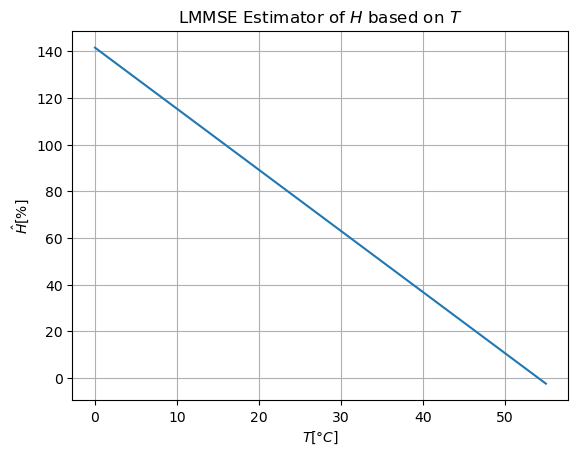

In [10]:
# Using the MMSE estimator without restrictions of H based on T described above to estimate the value of H 
# based on the observations of T provided in the file greenhouse50temp.txt.
filename2 = 'greenhouse50temp.txt'
T50 = np.loadtxt(filename2)

# Linear estimator of H is created.
def Hhat(muH, muT, covHT, sigmaT, T):
    return muH + (covHT/sigmaT)*(T-muT)

# Estimate the value of H for the T_est values.
T_est = np.linspace(0, 55, 50)
Hh = []

# For each value of T in T_est, calculate its corresponding estimated H.
for i in range(len(T_est)):
    Hh.append(Hhat(mu_Z[1], mu_Z[0], Q_Z[1, 0], Q_Z[0,0], T_est[i]))

# Plot the LMMSE estimator of H based on T.
plt.plot(T_est, Hh)
plt.grid()
plt.xlabel(r'$T [°C]$')
plt.ylabel(r'$\hat{H} [\%]$')
plt.title(r'LMMSE Estimator of $H$ based on $T$')
plt.show()


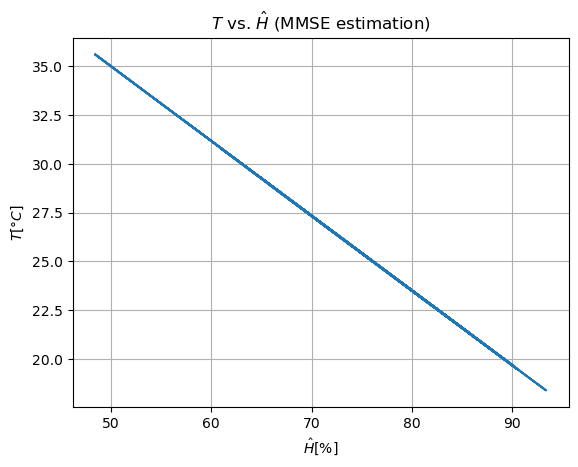

In [11]:
# Estimate the humidity values with respect to those obtained in the file greenhouse50temp.txt.
H50_estimated = np.zeros((len(T50), 1))
for i in range(len(T50)):
    H_estimated = np.round(Hhat(mu_Z[1], mu_Z[0], Q_Z[1, 0], Q_Z[0,0], T50[i]), 1)
    H50_estimated[i] = H_estimated

# Plot the T values from the file greenhouse50temp.txt against the newly estimated values.
plt.plot(H50_estimated, T50)
plt.grid()
plt.xlabel(r'$\hat{H} [\%]$')
plt.ylabel(r'$T [°C]$')
plt.title(r'$T$ vs. $\hat{H}$ (MMSE estimation)')
plt.show()


#### ii) Estimation using integral definition

Let $f_Z(t, h) = \sum_{k=1}^{3} \alpha_k N(t, h; \mu_k, Q_k)$ be the distribution found in item d). We write a routine that, given a temperature observation t, calculates

$$\hat{H}(t) = E[H|T=t] = \int_{-\infty}^{\infty}h f_H(h|T=t)dh$$

Using this routine, we find the humidity estimate based on the 50 temperature observations. We plot $T$ vs. $\hat{H}$, where $\hat{H}(t)$ refers to the humidity estimation based on the temperature observation $t$.

Recall that
$$f_H(h|T=t) = \frac{f_Z(t,h)}{f_T(t)}$$
and that
$$f_T(t) = \int_{-\infty}^{\infty}f_Z(t,h)dh$$


In [12]:
# Description of scipy.integrate:
# The first argument to quad is a “callable” Python object (i.e., a function, method, or class instance). The next two arguments are the limits of integration. 
# The return value is a tuple, with the first element holding the estimated value of the integral and the second element holding an upper bound on the error.

# Define the function f_Z(t, h)
def f_Z(h, t):
    return float(alphas3[0]*gauss(np.array([[t, h]]).T, params3[0][0], params3[0][1]) + alphas3[1]*gauss(np.array([[t, h]]).T, params3[1][0], params3[1][1]) + alphas3[2]*gauss(np.array([[t, h]]).T, params3[2][0], params3[2][1]))

# Define the function f_H(t, h)
def f_H(h, t):
    f_T = integrate.quad(f_Z, -np.inf, np.inf, args=(t,))
    return (f_Z(h, t))/(f_T[0])

# Define the integrand to calculate the estimate of H.
def integrand(h, t):
    return h*f_H(h, t)

# Function to calculate the estimate of H from known values of T. Integrates from 0 to 100 instead of -inf to inf to avoid underflow errors in the computation of integrals.
def Hhat_integral(t):
    return integrate.quad(integrand, 0, 100, args=(t,))


#### The estimation of humidity based on the 50 temperature observations is found:

In [13]:
# Estimate the humidity values with respect to those obtained in the file greenhouse50temp.txt.
H50_estimated_integral = np.zeros((len(T50), 1))
for i in range(len(T50)):
    H_estimated = Hhat_integral(T50[i])
    H50_estimated_integral[i] = H_estimated[0]

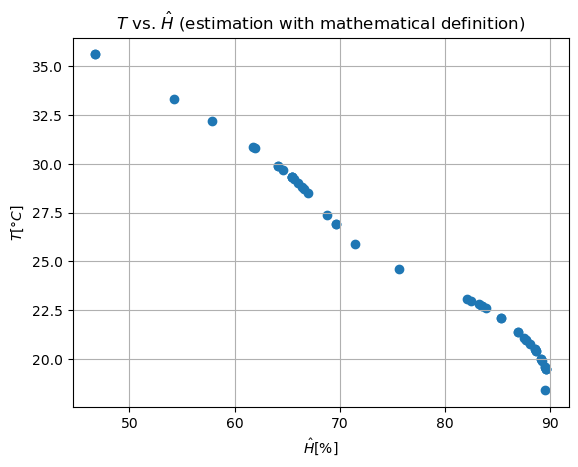

In [14]:
# Plot the T values from the file greenhouse50temp.txt against the newly estimated values.
plt.scatter(H50_estimated_integral, T50)
plt.grid()
plt.xlabel(r'$\hat{H} [\%]$')
plt.ylabel(r'$T [°C]$')
plt.title(r'$T$ vs. $\hat{H}$ (estimation with mathematical definition)')
plt.show()

### iii) Recovered humidity data

Eventually, the actual humidity observations associated with the 50 temperature observations were recovered. These are found in the file *greenhouse50hum.txt*. It is desired to determine which of the two humidity estimators was the most accurate: the one found in item (i) or the one found in item (ii). For this, in both cases, we calculate the error:

$$error = \frac{1}{50}\sum_{i=1}^{50}\left(h_i - \hat{H}(t_i)\right)^2$$

where $h_i$ and $t_i$ refer to the actual humidity and temperature values, and $\hat{H}(t_i)$ refers to the estimation of $h_i$ given by each estimator separately. Based on this error, we determine which of the estimators would be the most suitable to use regarding accuracy and computation time.


In [15]:
# Define the error function
# h and Hhat are vectors of the same size.
# Returns the numerical value of the error function
def error(h, Hhat):
    sum = 0
    for i in range(len(h)):
        sum = sum + (h[i] - Hhat[i])**2
    return np.round(float((1/len(h))*sum), 2)

# Import real humidity data
filename3 = 'greenhouse50hum.txt'
H50 = np.loadtxt(filename3)

# Calculate the error obtained for the linear MMSE estimator (single Gaussian).
error1 = error(H50, H50_estimated)

# Calculate the error obtained for the estimator given by the mathematical definition.
error3 = error(H50, H50_estimated_integral)

print(f'Error with 1 Gaussian:\n {error1}\n')
print(f'Error with 3 Gaussians:\n {error3}\n')

if error1 > error3:
    print('The most suitable estimator to use in terms of precision is the estimator found from the combination of 3 Gaussians.')
else:
    print('The most suitable estimator to use in terms of precision is the estimator found from 1 Gaussian.')

print('The most suitable estimator to use in terms of computation time is the estimator found from 1 Gaussian.')


Error with 1 Gaussian:
 64.77

Error with 3 Gaussians:
 64.74

The most suitable estimator to use in terms of precision is the estimator found from the combination of 3 Gaussians.
The most suitable estimator to use in terms of computation time is the estimator found from 1 Gaussian.


### Plot comparing estimators

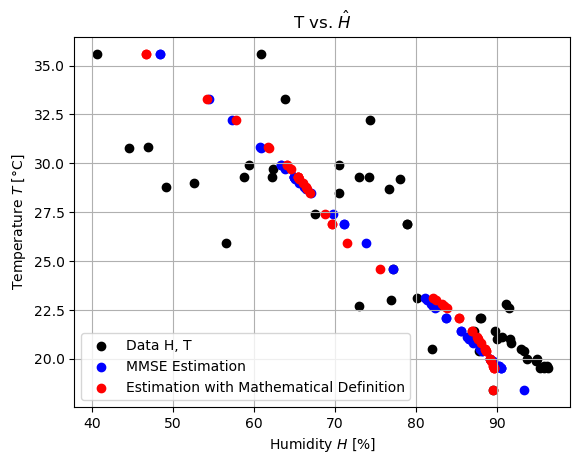

In [16]:
plt.scatter(H50, T50, c='k', label='Data H, T')
plt.scatter(H50_estimated, T50, c='b', label='MMSE Estimation')
plt.scatter(H50_estimated_integral, T50, c='r', label='Estimation with Mathematical Definition')
plt.grid()
plt.legend()
plt.xlabel(r'Humidity $H$ [%]')
plt.ylabel(r'Temperature $T$ [°C]')
plt.title(r'T vs. $\hat{H}$')
plt.show()